# **Building your own LLM**  

### The Transformer Architecture

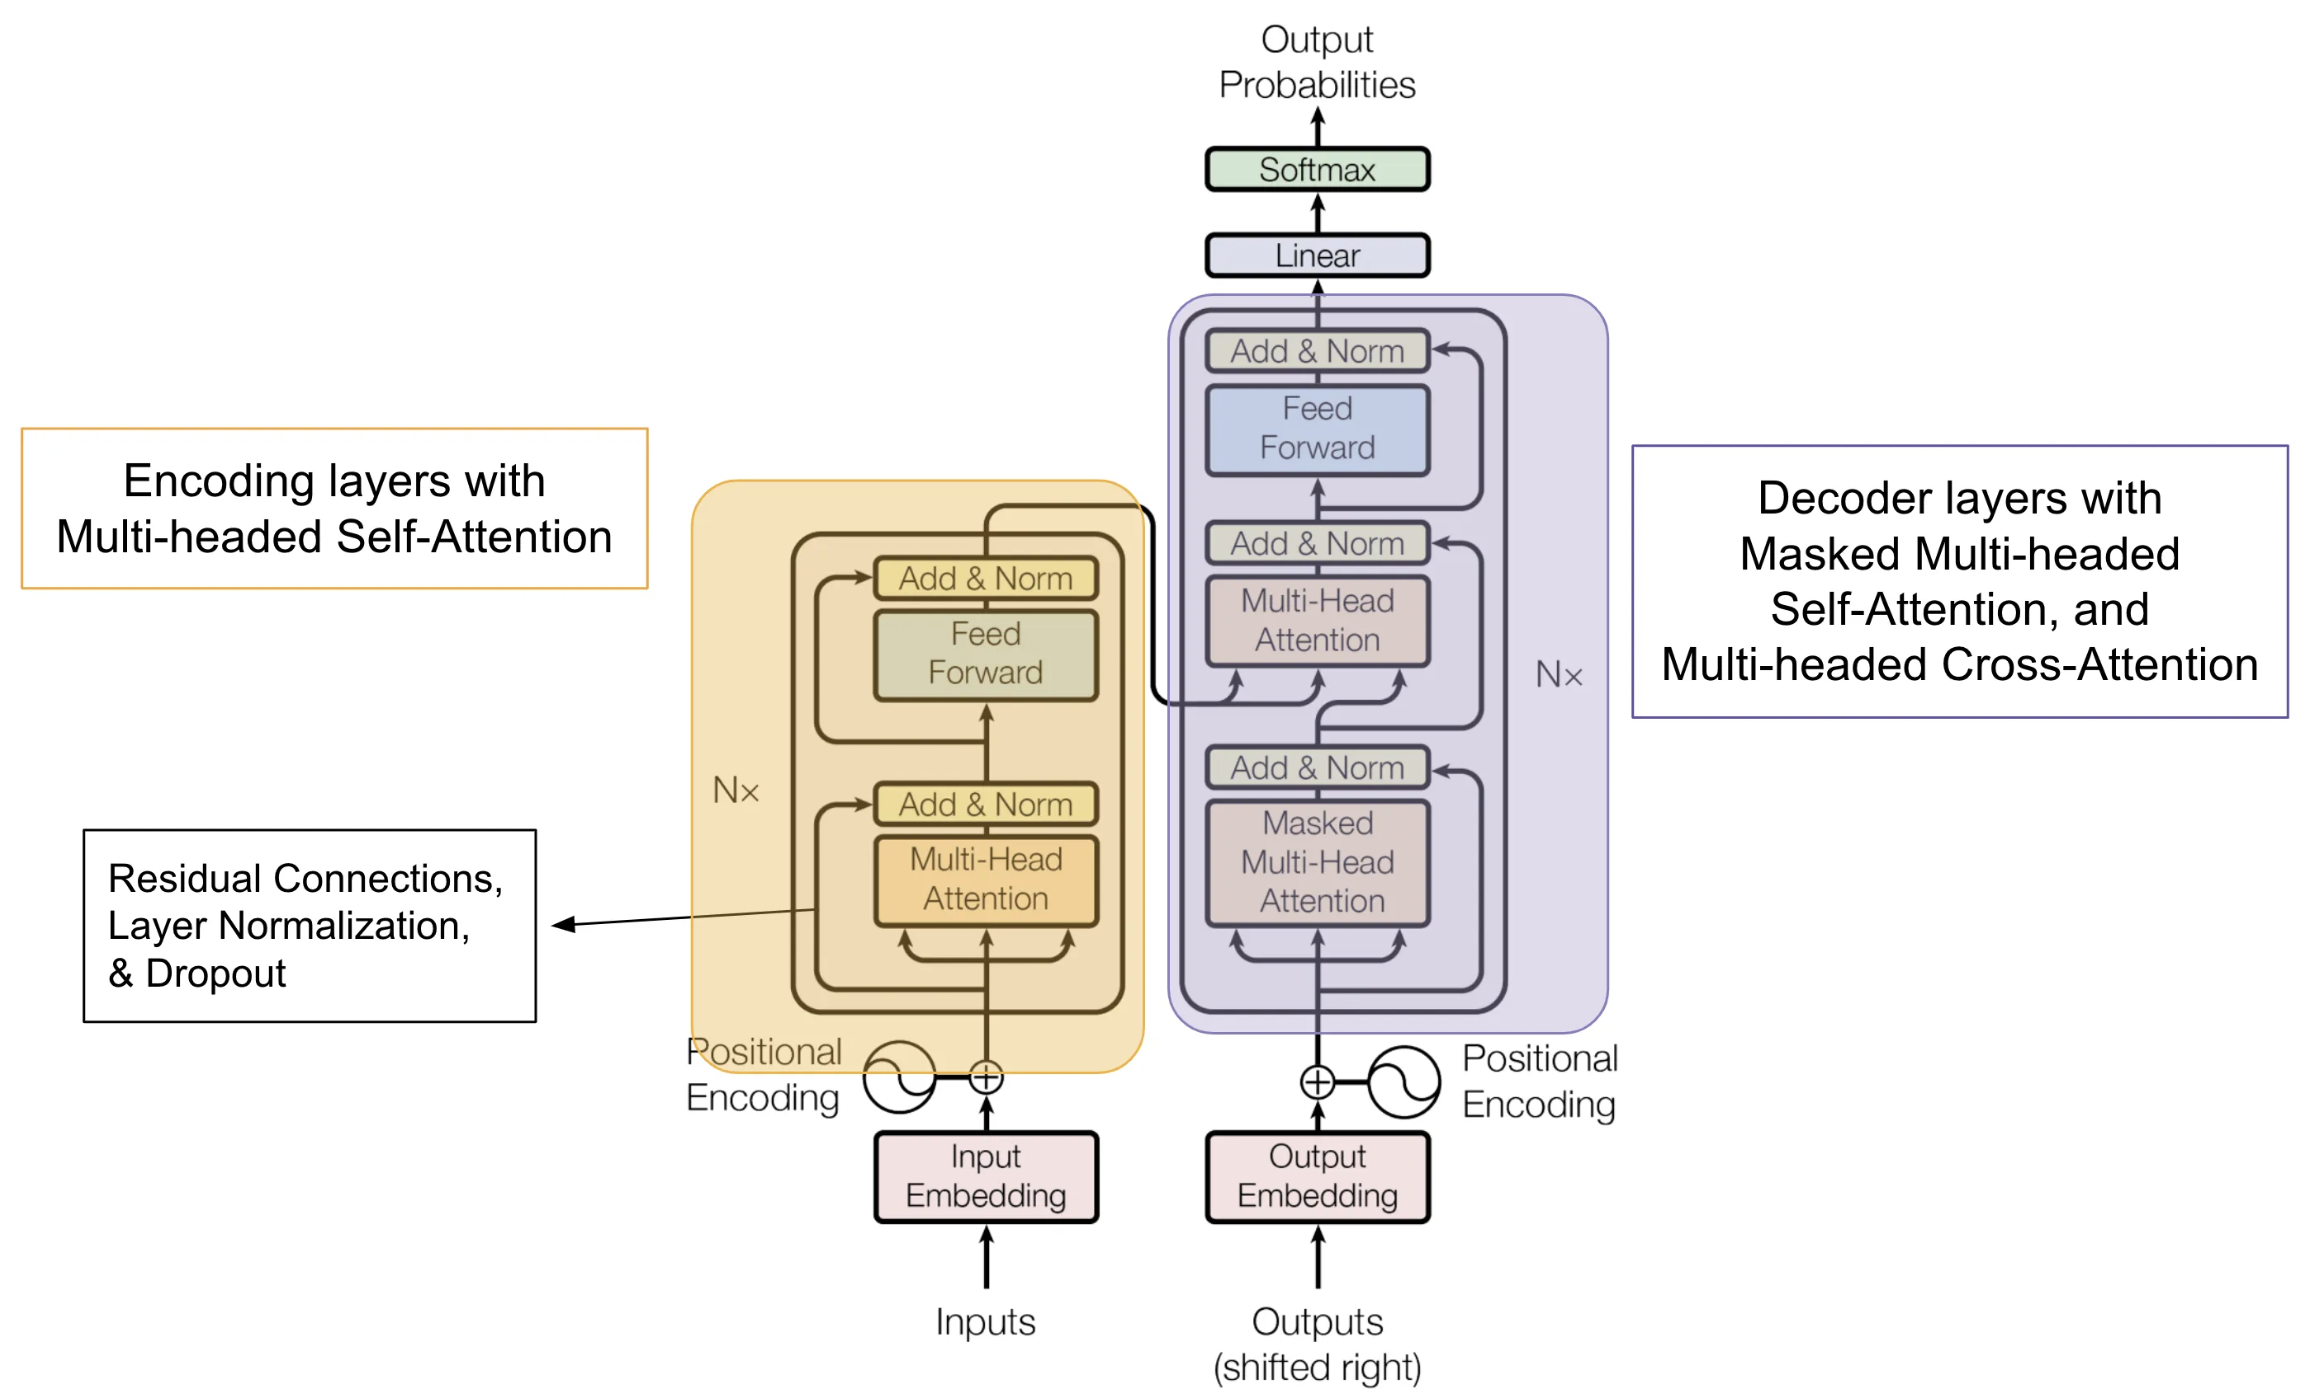

At its core, this architecture operates almost entirely through mechanisms known as attention, combined with standard components like feedforward neural layers and simple linear transformations. Here's a visual reference for context:


Today, the Transformer and its evolving adaptations serve as the brain behind virtually all large-scale language AI systems. If you're interacting with a chatbot or using a tool that generates natural text, chances are it's powered by this family of models.

---


The original Transformer design is made up of two major sections: an **input processor**, or encoder, and an **output generator**, or decoder. This dual structure was initially developed to support translation tasks between languages.

The **encoder** takes an incoming sentence and runs it through a stack of identical modules that distill the sequence into a condensed, informative representation. This output then becomes the context for the **decoder**, which generates new text one piece at a time.

---

### Inside the Encoder

Each encoder module includes three essential operations:

1. **Multi-head self-attention** — This component allows the model to examine different parts of a sentence simultaneously, creating context-rich token representations. It’s the cornerstone of what makes Transformers powerful.
2. **Independent neural processing per token** — A multi-layer perceptron (MLP) processes each token individually, refining its representation.
3. **Layer normalization and residual paths** — To support deep stacking of layers, residual shortcuts and normalization are introduced, ensuring smooth learning and mitigating vanishing gradient issues.

---

### Inside the Decoder

The decoder has a similar structure but introduces a couple of differences to support autoregressive generation:

1. **Causal (masked) self-attention** — This ensures the model only considers previously seen tokens when predicting the next one, preserving a left-to-right flow.
2. **Cross-attention** — The decoder links back to the encoder’s output through this mechanism, allowing it to reference the input during generation.
3. **Token-wise MLP processing** — Same as the encoder, a feedforward network processes each token.
4. **Skip connections with normalization** — Just like in the encoder, these help stabilize training.

---

### Variants and Evolution

Over time, researchers have experimented with modifying this structure. Some models drop the encoder altogether and focus only on the decoder — a design that underpins popular systems like GPT-2, GPT-3, and Microsoft's Turing-NLG.

These **decoder-only** architectures streamline the Transformer design by removing the cross-attention layer, since there is no encoder output to attend to. The model simply learns to predict the next token using only previous ones:


---

### Final Note

So, when constructing a language model today, the focus is often on this simplified form, which is optimized for generating fluent and coherent text based on a sequence of prior words.


### Tokenization + Positional encoding


#### Tokenization


Before Transformers can process language, raw text must be converted into a format they understand — they cannot directly work with plain strings. This is where **tokenization** comes into play.

The original sentence is first broken down into smaller units known as **tokens**. Each token is then mapped to a numerical identifier, and that ID is associated with a dense vector known as an **embedding**, which typically has a fixed dimensional size, often denoted as $d_{model}$. These vectors can either be learned from scratch during training or borrowed from pre-trained embedding tables.

Once the text has been converted into a sequence of token embeddings, this sequence becomes the actual input to the Transformer model.

\\


---

### Why Tokenization Matters

Token IDs are the building blocks that models use to understand and generate language. When completing a sentence, predicting the next word, or filling in blanks, the model does this at the token level — not with entire words or characters.

This transformation from text to tokens and then to token IDs is known as [**tokenization**](https://huggingface.co/docs/transformers/tokenizer_summary). There are different tokenization strategies, some of which are trained on massive datasets to understand how best to segment text.

When working with **pre-trained Transformer models**, it's essential to use the exact same tokenization approach that was used during their training — otherwise, the input won't match what the model expects, leading to poor performance or incorrect outputs.

---

### Example: Tokenizing with BERT

let’s take a look at how the [BERT model](https://arxiv.org/abs/1810.04805) tokenizes an input sentence. We’ll use the tools provided by [Hugging Face](https://huggingface.co/) to explore how this transformation happens under the hood and see the intermediate token representations before they’re passed into the model.


In [ ]:
import transformers
from transformers import pipeline, AutoTokenizer, AutoModel

bert_tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
encoded_input = bert_tokenizer("The practical is so much fun")
print(f"Token IDs: {encoded_input['input_ids']}")

In [ ]:
print(f"Tokens: {bert_tokenizer.decode(encoded_input['input_ids'])}")

### Understanding Special Tokens and Sequence Awareness in Transformers

When working with transformer-based models like BERT, you'll notice that tokenizers introduce special tokens at the beginning and end of text sequences. For example, `[CLS]` is prepended, and `[SEP]` is appended. These tokens aren't part of the original sentence — they're added deliberately to signal boundaries or structure within the data.

These special tokens play a critical role in how transformers interpret input. They help the model determine where the sequence starts and ends or where different segments of input are divided. This structure is especially important when tackling complex tasks like sentence classification or question answering.

---

### Masked Language Modeling: Teaching Models to Guess Missing Words

One clever technique used during the pretraining of models like BERT is **masked language modeling**. Here’s how it works: some words in a sentence are randomly hidden and replaced with a `[MASK]` token. The model is then trained to predict the original word based on the surrounding context.

This form of self-supervised learning enables the model to build a nuanced understanding of word relationships and sentence structure without needing manually labeled data.

---

### Why Word Order Matters: A Limitation of Raw Tokens

Using token IDs alone doesn’t tell the model **where** each word appeared in the sentence. This becomes a problem when we consider that word order affects meaning. For example:

- "I am happy"
- "Am I happy?"

Both sentences contain the same words, but they convey different sentiments and grammatical structures. Without knowledge of position, a model would struggle to distinguish between them.

---



#### Positional encodings

### Adding Positional Information: The Role of Positional Embeddings

To fix this, transformers introduce **positional encodings**. These are additional vectors that represent the relative or absolute position of each token in the sequence. When added to the token embeddings, they give the model the ability to understand **sequence order**, which is essential for capturing the meaning behind word placement.

Together, token embeddings, special markers, and positional information enable transformer models to handle the richness and complexity of human language more effectively.

In [ ]:
def return_frequency_pe_matrix(token_sequence_length, token_embedding):

  assert token_embedding % 2 == 0, "token_embedding should be divisible by two"

  P = jnp.zeros((token_sequence_length, token_embedding))
  positions = jnp.arange(0, token_sequence_length)[:, jnp.newaxis]

  i = jnp.arange(0, token_embedding, 2)
  frequency_steps = jnp.exp(i * (-math.log(10000.0) / token_embedding))
  frequencies = positions * frequency_steps

  P = P.at[:, 0::2].set(jnp.sin(frequencies))
  P = P.at[:, 1::2].set(jnp.cos(frequencies))

  return P

In [ ]:
token_sequence_length = 50
token_embedding = 10000
P = return_frequency_pe_matrix(token_sequence_length, token_embedding)
p


####  Feed Forward Network (FFN)

In [ ]:
class FeedForwardBlock(nn.Module):
    """A 2-layer MLP (Multi-Layer Perceptron) that first expands the input size and then reduces it back."""

    # widening_factor controls how much the input dimension is expanded in the first layer.
    widening_factor: int = 4

    # init_scale controls the scaling factor for weight initialization.
    init_scale: float = 0.25

    @nn.compact
    def __call__(self, x):
        # Get the size of the last dimension of the input (embedding size).
        d_m = x.shape[-1]

        # Calculate the size of the first layer by multiplying the embedding size by the widening factor.
        layer1_size = self.widening_factor * d_m

        # Initialize the weights for both layers using a variance scaling initializer.
        initializer = nn.initializers.variance_scaling(
            scale=self.init_scale, mode='fan_in', distribution='truncated_normal',
        )

        # Define the first dense layer, which expands the input size.
        layer1 = nn.Dense(layer1_size, kernel_init=initializer)

        # Define the second dense layer, which reduces the size back to the original dimension.
        layer2 = nn.Dense(d_m, kernel_init=initializer)

        # Apply the first dense layer followed by a GELU activation function.
        x = jax.nn.gelu(layer1(x))

        # Apply the second dense layer to project the data back to its original dimension.
        x = layer2(x)

        # Return the final output.
        return x

#### Add and Norm block

In [ ]:
class AddNorm(nn.Module):
    """A block that implements the 'Add and Norm' operation used in transformers."""

    @nn.compact
    def __call__(self, x, processed_x):
        # Step 1: Add the original input (x) to the processed input (processed_x).
        added = x + processed_x

        # Step 2: Apply layer normalization to the result of the addition.
        # - LayerNorm helps to stabilize and improve the training process by normalizing the output.
        # - reduction_axes=-1 indicates that normalization is applied across the last dimension (typically the embedding dimension).
        # - use_scale=True and use_bias=True allow the layer to learn scaling and bias parameters for further fine-tuning.
        normalised = nn.LayerNorm(reduction_axes=-1, use_scale=True, use_bias=True)

        # Return the normalized result.
        return normalised(added)

###  Building the Transformer Decoder

In [ ]:
class DecoderBlock(nn.Module):
    """
    Transformer decoder block.

    Args:
        num_heads: The number of attention heads in the Multi-Head Attention (MHA) block.
        d_m: The size of the token embeddings.
        widening_factor: The factor by which the hidden layer size is expanded in the MLP.
    """

    num_heads: int
    d_m: int
    widening_factor: int = 4

    def setup(self):
        # Initialize the Multi-Head Attention (MHA) block
        self.mha = MultiHeadAttention(self.num_heads, self.d_m)

        # Initialize the AddNorm blocks for residual connections and normalization
        self.add_norm1 = AddNorm()  # First AddNorm block after MHA
        self.add_norm2 = AddNorm()  # Second AddNorm block after the MLP

        # Initialize the FeedForwardBlock (MLP) which processes the data after attention
        self.MLP = FeedForwardBlock(widening_factor=self.widening_factor)

    def __call__(self, X, mask=None, return_att_weight=True):
        """
        Forward pass through the DecoderBlock.

        Args:
            X: Batch of input tokens fed into the decoder, shape [B, T_decoder, d_m]
            mask [optional, default=None]: Mask to control which positions the attention is allowed to consider, shape [T_decoder, T_decoder].
            return_att_weight [optional, default=True]: If True, returns the attention weights along with the output.

        Returns:
            If return_att_weight is True, returns a tuple (X, attention_weights_1).
            Otherwise, returns the processed token representations X.
        """

        # Apply Multi-Head Attention to the input tokens (X) with optional masking
        attention, attention_weights_1 = self.mha(X, mask=mask, return_weights=True)

        # Apply the first AddNorm block (adds the original input X and normalizes)
        X = self.add_norm1(X, attention)

        # Pass the result through the FeedForwardBlock (MLP) to further process the data
        projection = self.MLP(X)

        # Apply the second AddNorm block (adds the input from the previous step and normalizes)
        X = self.add_norm2(X, projection)

        # Return the final output X, and optionally the attention weights
        return (X, attention_weights_1) if return_att_weight else X


In [ ]:
class LLM(nn.Module):
    """
    Transformer model consisting of several layers of decoder blocks.

    Args:
        num_heads: Number of attention heads in each Multi-Head Attention (MHA) block.
        num_layers: Number of decoder blocks in the model.
        d_m: Dimensionality of the token embeddings.
        vocab_size: Size of the vocabulary (number of unique tokens).
        widening_factor: Factor by which the hidden layer size is expanded in the MLP.
    """
    num_heads: int
    num_layers: int
    d_m: int
    vocab_size: int
    widening_factor: int = 4

    def setup(self):
        # Initialize a list of decoder blocks, one for each layer in the model
        self.blocks = [
            DecoderBlock(self.num_heads, self.d_m, self.widening_factor)
            for _ in range(self.num_layers)
        ]

        # Initialize an embedding layer to convert token IDs into token embeddings
        self.embedding = nn.Embed(num_embeddings=self.vocab_size, features=self.d_m)

        # Initialize a dense layer for predicting the next token in the sequence
        self.pred_layer = nn.Dense(self.vocab_size)

    def __call__(self, X, mask=None, return_att_weights=False):
        """
        Forward pass through the LLM model.

        Args:
            X: Batch of input token IDs, shape [B, T_decoder] where B is batch size and T_decoder is sequence length.
            mask [optional, default=None]: Mask to control which positions the attention can focus on, shape [T_decoder, T_decoder].
            return_att_weights [optional, default=False]: Whether to return the attention weights.

        Returns:
            logits: The predicted probabilities for each token in the vocabulary.
            If return_att_weights is True, also returns the attention weights.
        """

        # Convert token IDs to embeddings (shape [B, T_decoder, d_m])
        X = self.embedding(X)

        # Get the sequence length of the input
        sequence_len = X.shape[-2]

        # Generate positional encodings and add them to the token embeddings
        positions = return_frequency_pe_matrix(sequence_len, self.d_m)
        X = X + positions

        # Initialize a list to store attention weights if needed
        if return_att_weights:
            att_weights = []

        # Pass the embeddings through each decoder block in sequence
        for block in self.blocks:
            out = block(X, mask, return_att_weights)
            if return_att_weights:
                # If returning attention weights, unpack the output
                X = out[0]
                att_weights.append(out[1])
            else:
                # Otherwise, just update the input for the next block
                X = out

        # Apply a dense layer followed by a log softmax to get logits (predicted token probabilities)
        logits = nn.log_softmax(self.pred_layer(X))

        # Return the logits, and optionally, the attention weights
        return logits if not return_att_weights else (logits, jnp.array(att_weights).swapaxes(0, 1))

Now everything should run without any issues.

In [ ]:
B, T, d_m, N, vocab_size = 18, 32, 16, 8, 25670

llm = LLM(num_heads=1, num_layers=1, d_m=d_m, vocab_size=vocab_size, widening_factor=4)
mask = jnp.tril(np.ones((T, T)))

# initialise module and get dummy output
key = jax.random.PRNGKey(42)
X = jax.random.randint(key, [B, T], 0, vocab_size)
params = llm.init(key, X, mask=mask)

# extract output from decoder
logits, decoder_att_weights = llm.apply(
    params,
    X,
    mask=mask,
    return_att_weights=True,
)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.suptitle("LLM attention weights")
sns.heatmap(decoder_att_weights[0, 0, 0, ...], ax=ax, cmap="Blues")
fig.show()

The attention weights should be working correctly.

###  Training your LLM

In [ ]:
def sequence_loss_fn(logits, targets):
    """Compute the sequence loss between predicted logits and target labels."""

    # Convert the target indices to one-hot encoded vectors.
    # Each target label is converted into a one-hot vector of size VOCAB_SIZE.
    target_labels = jax.nn.one_hot(targets, VOCAB_SIZE)

    # Ensure that the shape of logits matches the shape of the one-hot encoded targets.
    # This is important because we need to compute the loss across matching dimensions.
    assert logits.shape == target_labels.shape

    # Create a mask that ignores padding tokens in the loss calculation.
    # The mask is True (1) where the target value is greater than 0 and False (0) otherwise.
    mask = jnp.greater(targets, 0)

    # Compute the cross-entropy loss for each token.
    # Cross-entropy is calculated as the negative log probability of the correct class.
    # jax.nn.log_softmax(logits) gives us the log probabilities for each class.
    # We multiply by the target_labels to select the log probability of the correct class.
    loss = -jnp.sum(target_labels * jax.nn.log_softmax(logits), axis=-1)

    # Apply the mask to the loss to ignore padding positions and sum up the losses.
    # We then normalize the total loss by the number of non-padding tokens.
    loss = jnp.sum(loss * mask) / jnp.sum(mask)

    return loss

In [ ]:
VOCAB_SIZE = 25670
targets = jnp.array([[0, 2, 0]])
key = jax.random.PRNGKey(42)
X = jax.random.normal(key, [1, 3, VOCAB_SIZE])
loss = sequence_loss_fn(X, targets)
real_loss = jnp.array(10.966118)
assert jnp.allclose(real_loss, loss), "Not returning the correct value"
print("It seems correct. Look at the answer below to compare methods.")

## Create Dataset for Training

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O input.txt

class WordBasedAsciiDatasetForLLM:
    """In-memory dataset of a single-file ASCII dataset for language-like model."""

    def __init__(self, path: str, batch_size: int, sequence_length: int):
        """Load a single-file ASCII dataset in memory."""
        self._batch_size = batch_size

        with open(path, "r") as f:
            corpus = f.read()

        # Tokenize by splitting the text into words
        words = corpus.split()
        self.vocab_size = len(set(words))  # Number of unique words

        # Create a mapping from words to unique IDs
        self.word_to_id = {word: i for i, word in enumerate(set(words))}

        # Store the inverse mapping from IDs to words
        self.id_to_word = {i: word for word, i in self.word_to_id.items()}

        # Convert the words in the corpus to their corresponding IDs
        corpus = np.array([self.word_to_id[word] for word in words]).astype(np.int32)

        crop_len = sequence_length + 1
        num_batches, ragged = divmod(corpus.size, batch_size * crop_len)
        if ragged:
            corpus = corpus[:-ragged]
        corpus = corpus.reshape([-1, crop_len])

        if num_batches < 10:
            raise ValueError(
                f"Only {num_batches} batches; consider a shorter "
                "sequence or a smaller batch."
            )

        self._ds = WordBasedAsciiDatasetForLLM._infinite_shuffle(
            corpus, batch_size * 10
        )

    def __iter__(self):
        return self

    def __next__(self):
        """Yield next mini-batch."""
        batch = [next(self._ds) for _ in range(self._batch_size)]
        batch = np.stack(batch)
        # Create the language modeling observation/target pairs.
        return dict(
            input=batch[:, :-1], target=batch[:, 1:]
        )

    def ids_to_words(self, ids):
        """Convert a sequence of word IDs to words."""
        return [self.id_to_word[id] for id in ids]

    @staticmethod
    def _infinite_shuffle(iterable, buffer_size):
        """Infinitely repeat and shuffle data from iterable."""
        ds = itertools.cycle(iterable)
        buf = [next(ds) for _ in range(buffer_size)]
        random.shuffle(buf)
        while True:
            item = next(ds)
            idx = random.randint(0, buffer_size - 1)  # Inclusive.
            result, buf[idx] = buf[idx], item
            yield result


Lets now look how our data is structured for training

In [ ]:
# sample and look at the data
batch_size = 2
seq_length = 32
train_dataset = WordBasedAsciiDatasetForLLM("input.txt", batch_size, seq_length)

batch = next(train_dataset)

for obs, target in zip(batch["input"], batch["target"]):
    print("-" * 10, "Input", "-" * 11)
    print("TEXT:", ' '.join(train_dataset.ids_to_words(obs)))
    print("ASCII:", obs)
    print("-" * 10, "Target", "-" * 10)
    print("TEXT:", ' '.join(train_dataset.ids_to_words(target)))
    print("ASCII:", target)

print(f"\n Total vocabulary size: {train_dataset.vocab_size}")

VOCAB_SIZE = train_dataset.vocab_size

Next, let us train our LLM and see how it performs in producing Shakespearian text. First, we will define what happens for every training step.

In [ ]:
import functools

@functools.partial(jax.jit, static_argnums=(3, 4))
def train_step(params, optimizer_state, batch, apply_fn, update_fn):
    """
    Perform a single training step.

    Args:
        params: The current parameters of the model.
        optimizer_state: The current state of the optimizer.
        batch: A dictionary containing the input data and target labels for the batch.
        apply_fn: The function used to apply the model to the inputs.
        update_fn: The function used to update the model parameters based on the gradients.

    Returns:
        Updated parameters, updated optimizer state, and the computed loss for the batch.
    """

    def loss_fn(params):
        # Get the sequence length (T) from the input data.
        T = batch['input'].shape[1]

        # Apply the model to the input data, using a lower triangular mask to enforce causality.
        # jnp.tril(np.ones((T, T))) creates a lower triangular matrix of ones.
        logits = apply_fn(params, batch['input'], jnp.tril(np.ones((T, T))))

        # Calculate the loss between the predicted logits and the target labels.
        loss = sequence_loss_fn(logits, batch['target'])

        return loss

    # Compute the loss and its gradients with respect to the parameters.
    loss, gradients = jax.value_and_grad(loss_fn)(params)

    # Update the optimizer state and calculate the parameter updates based on the gradients.
    updates, optimizer_state = update_fn(gradients, optimizer_state)

    # Apply the updates to the parameters.
    params = optax.apply_updates(params, updates)

    # Return the updated parameters, optimizer state, and the loss for the batch.
    return params, optimizer_state, loss

Next we initialise our optimizer and model. Feel free to play with the hyperparameters during the practical.

In [ ]:
# Define all hyperparameters
d_model = 128            # Dimension of token embeddings (d_m)
num_heads = 4            # Number of attention heads in Multi-Head Attention
num_layers = 1           # Number of decoder blocks in the model
widening_factor = 2      # Factor to widen the hidden layer size in the MLP
LR = 2e-3                # Learning rate for the optimizer
batch_size = 32          # Number of samples per training batch
seq_length = 64          # Length of each input sequence (number of tokens)

# Set up the training data
train_dataset = WordBasedAsciiDatasetForLLM("input.txt", batch_size, seq_length)
vocab_size = train_dataset.vocab_size  # Get the size of the vocabulary from the dataset
batch = next(train_dataset)            # Get the first batch of input data

# Set the random number generator key for model initialization
rng = jax.random.PRNGKey(42)

# Initialize the LLM model with the specified hyperparameters
llm = LLM(num_heads=num_heads, num_layers=num_layers, d_m=d_model, vocab_size=vocab_size, widening_factor=widening_factor)

# Create a causal mask to ensure that the model only attends to previous tokens
mask = jnp.tril(np.ones((batch['input'].shape[1], batch['input'].shape[1])))

# Initialize the model parameters using the first batch of input data and the mask
params = llm.init(rng, batch['input'], mask)

# Set up the optimizer using the Adam optimization algorithm with the specified learning rate
optimizer = optax.adam(LR, b1=0.9, b2=0.99)
optimizer_state = optimizer.init(params)  # Initialize the optimizer state with the model parameters

Now we train! This will take a few minutes..

In [ ]:
plotlosses = PlotLosses()

MAX_STEPS = 3500
LOG_EVERY = 32
losses = []
VOCAB_SIZE = 25670

# Training loop
for step in range(MAX_STEPS):
    batch = next(train_dataset)
    params, optimizer_state, loss = train_step(
        params, optimizer_state, batch, llm.apply, optimizer.update)
    losses.append(loss)
    if step % LOG_EVERY == 0:
        loss_ = jnp.array(losses).mean()
        plotlosses.update(
            {
                "loss": loss_,
            }
        )
        plotlosses.send()
        losses = []



Lets generate some text.

In [ ]:
import functools

@functools.partial(jax.jit, static_argnums=(2, ))
def generate_prediction(params, input, apply_fn):
  logits = apply_fn(params, input)
  argmax_out = jnp.argmax(logits, axis=-1)
  return argmax_out[0][-1].astype(int)

def generate_random_shakespeare(llm, params, id_2_word, word_2_id):
    '''
    Get the model output
    '''

    prompt = "Love"
    print(prompt, end="")
    tokens = prompt.split()

    # predict and append
    for i in range(15):
      input = jnp.array([[word_2_id[t] for t in tokens]]).astype(int)
      prediction = generate_prediction(params, input, llm.apply)
      prediction = id_2_word[int(prediction)]
      tokens.append(prediction)
      print(" "+prediction, end="")

    return " ".join(tokens)

id_2_word = train_dataset.id_to_word
word_2_id = train_dataset.word_to_id

generated_shakespeare = generate_random_shakespeare(llm, params, id_2_word, word_2_id)

And now you offecially created your own LLM from scratch!
